In [1]:
from time import sleep, time
from functions import *

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
connect(instruments)
reset(instruments)

In [4]:
instruments['OSC'].write("SYST:DISP:UPD 1")
instruments['DAQ'].set_conn(123)

## AWG

In [5]:
wf_dict_AWG = {
    'V' : [-2.6, 2.4], # pulse voltages
    'n' : [2, 2],   # pulse repetitions
    'T' : 1e-3,     # pulse period
    'W' : 1e-4,     # pulse width
    'read' : True,
    'read_V' : .1
}
ch_AWG = 1
get_and_set_wf('AWG', ch_AWG, wf_dict_AWG)

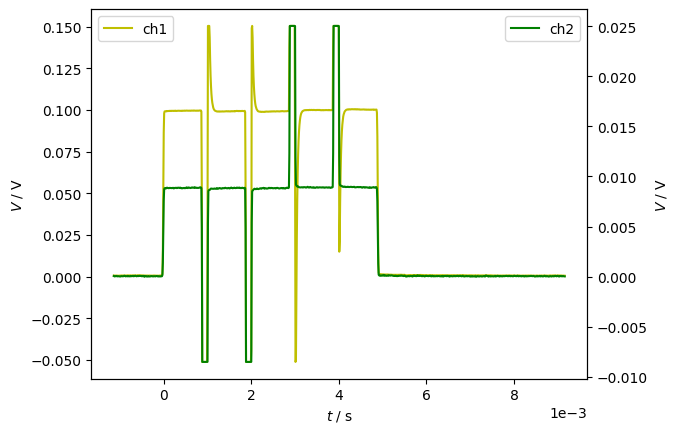

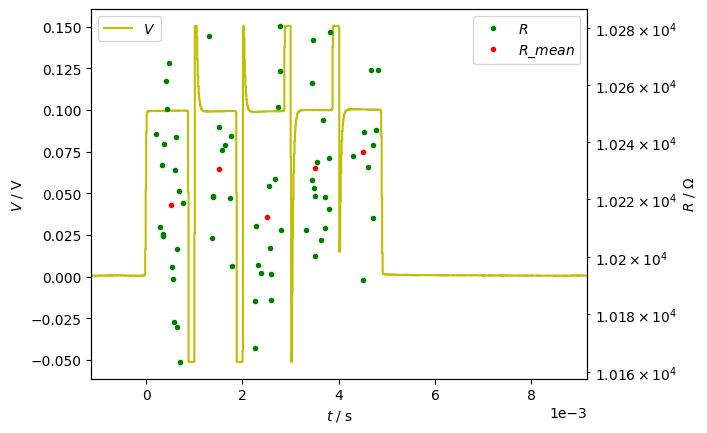

In [6]:
results_AWG = meas_AWG(113, ch_AWG, wf_dict_AWG, [1, 2], R_s=1e3, R_min=5e3)

In [7]:
with open(f"meas_dict_AWG_{date.today()}.json", "r") as json_file:
    meas_dict_AWG = json.load(json_file)

## SMU

In [8]:
wf_dict_SMU = {
    'V' : [1, -1],
    'n' : [5, 5],
    'T' : 1e-2,
    'W' : 1e-3,
    'read' : True,
    'read_V' : .1
}
ch_SMU = 2
get_and_set_wf('SMU', ch_SMU, wf_dict_SMU)

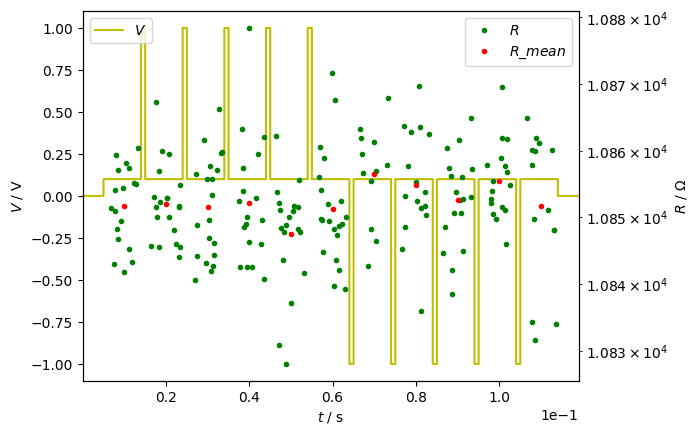

In [9]:
results_SMU = meas_SMU(111, ch_SMU, wf_dict_SMU, [1, 2])

In [10]:
with open(f"meas_dict_SMU_{date.today()}.json", "r") as json_file:
    meas_dict_SMU = json.load(json_file)

## AWG_SMU

In [11]:
wf_dict_AWG = {
    'V' : [1],
    'n' : [1],
    'T' : 1e-4,
    'W' : 1e-5,
    'read' : False,
    'read_V' : .1
}
ch_AWG = 1
get_and_set_wf('AWG', ch_AWG, wf_dict_AWG)

In [12]:
wf_dict_SMU = {
    'V' : [1],
    'n' : [0],
    'T' : 1,
    'W' : 0,
    'read' : True,
    'read_V' : .1
}
ch_SMU = 2
get_and_set_wf('SMU', ch_SMU, wf_dict_SMU, aint=True)

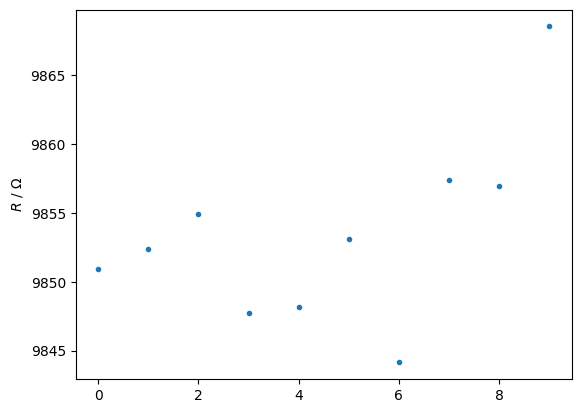

In [13]:
N = 10
R = meas_AWG_SMU(N, ch_AWG, ch_SMU, wf_dict_SMU, R_s = 1e3)